In [3]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [4]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [ ]:
# result1 = re.split(r'([,.])\s',text)
# result1

In [ ]:
result = [item for item in result if item.strip()]
result

['Hello,', 'world.', 'This,', 'is', 'a', 'test.']

In [ ]:
result = re.split(r'([,.:;?_!"()\']|--|\s)',text)
result = [item.strip() for item in result if item.strip()]
result

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']

In [ ]:
preprocced = re.split(r'([,.:;?_!"()\']|--|\s)',raw_text)
preprocced = [item.strip() for item in result if item.strip()]
print(preprocced[:20])

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


In [ ]:
len(preprocced)

10

In [ ]:
all_word = sorted(set(preprocced))
print(len(all_word))

8


In [ ]:
voc = {token:inte for inte , token in enumerate(all_word)}

In [ ]:
for i,item in enumerate(voc.items()):
    print(i,item)
    if i==10:
        break

0 (',', 0)
1 ('.', 1)
2 ('Hello', 2)
3 ('This', 3)
4 ('a', 4)
5 ('is', 5)
6 ('test', 6)
7 ('world', 7)


In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [ ]:
# tokenizer = SimpleTokenizerV1(voc)

# text = """"It's the last he painted, you know,"
#            Mrs. Gisburn said with pardonable pride."""
# ids = tokenizer.encode(text)
# print(ids)

In [ ]:
# tokenizer.decode(ids)

In [ ]:
# text_test = 'This is istiak Ahmed'
# print(tokenizer.encode(text_test))

In [ ]:
all_tokens = sorted(list(set(preprocced)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [ ]:
len(vocab.items())

10

In [ ]:
print(list(vocab.items())[-1])

('<|unk|>', 9)


In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [ ]:
tokenizer.encode(text)

[2, 0, 9, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 1]

In [ ]:
tokenizer.decode(tokenizer.encode(text))

'Hello, <|unk|> <|unk|> <|unk|> <|unk|> <|unk|> <|endoftext|> <|unk|> <|unk|> <|unk|> <|unk|> <|unk|> <|unk|> <|unk|>.'

In [ ]:
! pip3 install tiktoken

In [ ]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.11.0


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
tokenizer.decode(integers)

'Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.'

In [11]:
import torch
import torch.nn as nn

In [12]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

In [13]:


class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias)
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [14]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [28]:



class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [15]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.7867,  0.2203, -0.4508,  ..., -0.9936, -0.1412, -0.2999],
         [-0.0788,  0.3004, -0.2935,  ...,  0.1583,  0.8917,  0.8230],
         [ 0.3708,  1.1126, -0.3226,  ...,  0.8023, -0.0038,  0.3935],
         [ 0.0636,  1.0572, -0.2507,  ...,  0.7542, -0.0750, -0.6896]],

        [[-0.7208,  0.1351, -0.6014,  ..., -1.0272,  0.1729, -0.2920],
         [-0.5938,  0.4453, -0.0059,  ...,  0.3414,  0.0572,  1.0986],
         [ 0.2675,  0.8407, -0.4476,  ..., -0.0181, -0.1090,  0.2541],
         [-0.1035, -0.5901, -0.3932,  ...,  1.4022, -0.3188,  0.1304]]],
       grad_fn=<UnsafeViewBackward0>)


In [16]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [17]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [18]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [20]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [21]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [22]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [23]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [24]:
# model.eval() #A
# out = generate_text_simple(
# model=model,
# idx=encoded_tensor,
# max_new_tokens=6,
# context_size=GPT_CONFIG_124M["context_length"]
# )
# print("Output:", out)
# print("Output length:", len(out[0]))

NameError: name 'model' is not defined

In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am drone Omni SSLvoidDark 2021


In [ ]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [ ]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [ ]:
class GPTClassifierSMS(nn.Module):
    def __init__(self, cfg, num_labels=2):
        super().__init__()
        self.gpt = GPTModel(cfg)   # reuse your GPT
        self.classifier = nn.Linear(cfg["emb_dim"], num_labels)

    def forward(self, in_idx):
        # Get hidden states from GPT
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.gpt.tok_emb(in_idx)
        pos_embeds = self.gpt.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.gpt.drop_emb(x)
        x = self.gpt.trf_blocks(x)
        x = self.gpt.final_norm(x)

        # Instead of vocab logits, use last token embedding
        last_hidden = x[:, -1, :]                # [batch, emb_dim]
        logits = self.classifier(last_hidden)    # [batch, num_labels]

        return logits


In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [29]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [30]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [31]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [32]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [33]:
import torch
print("CUDA available:", torch.cuda.is_available())


CUDA available: False


In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Note:
# # Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# # which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# # However, the resulting loss values may be slightly different.

# #if torch.cuda.is_available():
# #    device = torch.device("cuda")
# #elif torch.backends.mps.is_available():
# #    device = torch.device("mps")
# #else:
# #    device = torch.device("cpu")
# #
# # print(f"Using {device} device.")


# model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


# torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

# with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
#     train_loss = calc_loss_loader(train_loader, model, device)
#     val_loss = calc_loss_loader(val_loader, model, device)

# print("Training loss:", train_loss)
# print("Validation loss:", val_loss)

NameError: name 'train_loader' is not defined

In [35]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [36]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [37]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [38]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [39]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"



token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [40]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Note:
# # Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# # which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# # However, the resulting loss values may be slightly different.

# #if torch.cuda.is_available():
# #    device = torch.device("cuda")
# #elif torch.backends.mps.is_available():
# #    device = torch.device("mps")
# #else:
# #    device = torch.device("cpu")
# #
# # print(f"Using {device} device.")


# model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


# torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

# with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
#     train_loss = calc_loss_loader(train_loader, model, device)
#     val_loss = calc_loss_loader(val_loader, model, device)

# print("Training loss:", train_loss)
# print("Validation loss:", val_loss)

In [ ]:
# # Note:
# # Uncomment the following code to calculate the execution time
# import time
# start_time = time.time()

# torch.manual_seed(123)
# model = GPTModel(GPT_CONFIG_124M)
# model.to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

# num_epochs = 10
# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=5, eval_iter=5,
#     start_context="Every effort moves you", tokenizer=tokenizer
# )

# # Note:
# # Uncomment the following code to show the execution time
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [41]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [42]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youEveryiliaralso stabbed OrleansAllowsean 52anche crime winter unbeaten quoteembedreportprint earning


In [43]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(), "model.pth")

In [44]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [45]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [ ]:
# !pip install transformers torch

# from transformers import GPT2LMHeadModel, GPT2Tokenizer

# # Load the model and tokenizer
# model = GPT2LMHeadModel.from_pretrained("gpt2")
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# # Access the token embedding weights (wte)
# wte_weights = model.transformer.wte.weight
# print("Token embedding weight tensor dimensions:", wte_weights.shape)
# print(wte_weights)

In [46]:
from transformers import GPT2Config

# Load pretrained GPT-2 small (124M) configuration
hf_config = GPT2Config.from_pretrained("gpt2")

print(hf_config)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.55.4",
  "use_cache": true,
  "vocab_size": 50257
}



In [47]:
cfg_from_hf = {
    "vocab_size": hf_config.vocab_size,
    "context_length": hf_config.n_positions,
    "emb_dim": hf_config.n_embd,
    "n_layers": hf_config.n_layer,
    "n_heads": hf_config.n_head,
    "drop_rate": hf_config.resid_pdrop,  # dropout prob
    "qkv_bias": True                     # GPT-2 uses bias in qkv projections
}


In [48]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [49]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

# First, define the assign function if you haven't already
def assign(tensor, values):
    """Assign values to a tensor"""
    with torch.no_grad():
        if isinstance(values, np.ndarray):
            values = torch.from_numpy(values)
        return tensor.copy_(values)

# Load the pre-trained GPT-2 model
print("Loading pre-trained GPT-2 model...")
pretrained_model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Get the configuration from the pre-trained model
pretrained_config = pretrained_model.config

# Create your GPT configuration dictionary
GPT_CONFIG_124M = {
    "vocab_size": pretrained_config.vocab_size,
    "emb_dim": pretrained_config.n_embd,
    "context_length": pretrained_config.n_positions,
    "n_heads": pretrained_config.n_head,
    "n_layers": pretrained_config.n_layer,
    "drop_rate": pretrained_config.attn_pdrop,  # Using attention dropout rate
    "qkv_bias": True,  # GPT-2 uses bias in QKV projections
}

print("GPT Configuration loaded:")
for key, value in GPT_CONFIG_124M.items():
    print(f"  {key}: {value}")

# Initialize your model with the loaded configuration
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()  # Disable dropout during inference

# Now extract parameters from the pre-trained model
def extract_pretrained_params(pretrained_model):
    """Extract parameters from Hugging Face GPT-2 model"""
    params = {}

    # Extract token and position embeddings
    params['wte'] = pretrained_model.transformer.wte.weight.detach().numpy()
    params['wpe'] = pretrained_model.transformer.wpe.weight.detach().numpy()

    # Extract final layer norm parameters
    params['g'] = pretrained_model.transformer.ln_f.weight.detach().numpy()
    params['b'] = pretrained_model.transformer.ln_f.bias.detach().numpy()

    # Extract parameters from each transformer block
    params["blocks"] = []

    for block_idx, block in enumerate(pretrained_model.transformer.h):
        block_params = {}

        # Attention layer
        attn_params = {}
        c_attn = block.attn.c_attn

        # Split QKV weights and biases
        emb_dim = GPT_CONFIG_124M["emb_dim"]
        qkv_weight = c_attn.weight.detach().numpy()
        qkv_bias = c_attn.bias.detach().numpy()

        # Split into Q, K, V (each of dimension emb_dim)
        q_w, k_w, v_w = np.split(qkv_weight, 3, axis=1)
        q_b, k_b, v_b = np.split(qkv_bias, 3, axis=0)

        attn_params["c_attn"] = {
            "w": qkv_weight,
            "b": qkv_bias
        }

        # Output projection
        c_proj = block.attn.c_proj
        attn_params["c_proj"] = {
            "w": c_proj.weight.detach().numpy(),
            "b": c_proj.bias.detach().numpy() if c_proj.bias is not None else np.zeros(c_proj.weight.shape[0])
        }

        # MLP (feed forward) layer
        mlp_params = {}
        mlp_params["c_fc"] = {
            "w": block.mlp.c_fc.weight.detach().numpy(),
            "b": block.mlp.c_fc.bias.detach().numpy() if block.mlp.c_fc.bias is not None else np.zeros(block.mlp.c_fc.weight.shape[0])
        }
        mlp_params["c_proj"] = {
            "w": block.mlp.c_proj.weight.detach().numpy(),
            "b": block.mlp.c_proj.bias.detach().numpy() if block.mlp.c_proj.bias is not None else np.zeros(block.mlp.c_proj.weight.shape[0])
        }

        # Layer normalization parameters
        ln_1_params = {
            "g": block.ln_1.weight.detach().numpy(),
            "b": block.ln_1.bias.detach().numpy() if block.ln_1.bias is not None else np.zeros(block.ln_1.weight.shape[0])
        }
        ln_2_params = {
            "g": block.ln_2.weight.detach().numpy(),
            "b": block.ln_2.bias.detach().numpy() if block.ln_2.bias is not None else np.zeros(block.ln_2.weight.shape[0])
        }

        block_params["attn"] = attn_params
        block_params["mlp"] = mlp_params
        block_params["ln_1"] = ln_1_params
        block_params["ln_2"] = ln_2_params

        params["blocks"].append(block_params)

    return params

# Extract parameters from the pre-trained model
print("Extracting parameters from pre-trained model...")
pretrained_params = extract_pretrained_params(pretrained_model)

# Load weights into your custom model
print("Loading weights into custom model...")
load_weights_into_gpt(model, pretrained_params)

print("Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test the model with a sample input
print("\nTesting model with sample input...")
sample_input = torch.tensor([[tokenizer.bos_token_id, tokenizer.encode("hello")[0]]])
with torch.no_grad():
    output = model(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Sample output values: {output[0, 0, :5]}")  # First 5 logits of first token

Loading pre-trained GPT-2 model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

GPT Configuration loaded:
  vocab_size: 50257
  emb_dim: 768
  context_length: 1024
  n_heads: 12
  n_layers: 12
  drop_rate: 0.1
  qkv_bias: True
Extracting parameters from pre-trained model...
Loading weights into custom model...
Model loaded successfully!
Model parameters: 163,037,184

Testing model with sample input...
Input shape: torch.Size([1, 2])
Output shape: torch.Size([1, 2, 50257])
Sample output values: tensor([-43.4317, -39.8364, -43.0659, -42.8281, -43.5296])


In [50]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




In [ ]:
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [ ]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [ ]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
def create_balanced_dataset(df):

    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine ham "subset" with "spam"
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [ ]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [ ]:
def random_split(df, train_frac, validation_frac):
    # Shuffle the entire DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # Calculate split indices
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # Split the DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# Test size is implied to be 0.2 as the remainder


In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))

1045
149
300


In [ ]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [ ]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [ ]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [26]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

NameError: name 'train_dataset' is not defined

In [ ]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [ ]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [73]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])



In [11]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

# First, define the assign function if you haven't already
def assign(tensor, values):
    """Assign values to a tensor"""
    with torch.no_grad():
        if isinstance(values, np.ndarray):
            values = torch.from_numpy(values)
        return tensor.copy_(values)

# Load the pre-trained GPT-2 model
print("Loading pre-trained GPT-2 model...")
pretrained_model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Get the configuration from the pre-trained model
pretrained_config = pretrained_model.config

# Create your GPT configuration dictionary
GPT_CONFIG_124M = {
    "vocab_size": pretrained_config.vocab_size,
    "emb_dim": pretrained_config.n_embd,
    "context_length": pretrained_config.n_positions,
    "n_heads": pretrained_config.n_head,
    "n_layers": pretrained_config.n_layer,
    "drop_rate": pretrained_config.attn_pdrop,  # Using attention dropout rate
    "qkv_bias": True,  # GPT-2 uses bias in QKV projections
}

print("GPT Configuration loaded:")
for key, value in GPT_CONFIG_124M.items():
    print(f"  {key}: {value}")

# Initialize your model with the loaded configuration
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()  # Disable dropout during inference

# Now extract parameters from the pre-trained model
def extract_pretrained_params(pretrained_model):
    """Extract parameters from Hugging Face GPT-2 model"""
    params = {}

    # Extract token and position embeddings
    params['wte'] = pretrained_model.transformer.wte.weight.detach().numpy()
    params['wpe'] = pretrained_model.transformer.wpe.weight.detach().numpy()

    # Extract final layer norm parameters
    params['g'] = pretrained_model.transformer.ln_f.weight.detach().numpy()
    params['b'] = pretrained_model.transformer.ln_f.bias.detach().numpy()

    # Extract parameters from each transformer block
    params["blocks"] = []

    for block_idx, block in enumerate(pretrained_model.transformer.h):
        block_params = {}

        # Attention layer
        attn_params = {}
        c_attn = block.attn.c_attn

        # Split QKV weights and biases
        emb_dim = GPT_CONFIG_124M["emb_dim"]
        qkv_weight = c_attn.weight.detach().numpy()
        qkv_bias = c_attn.bias.detach().numpy()

        # Split into Q, K, V (each of dimension emb_dim)
        q_w, k_w, v_w = np.split(qkv_weight, 3, axis=1)
        q_b, k_b, v_b = np.split(qkv_bias, 3, axis=0)

        attn_params["c_attn"] = {
            "w": qkv_weight,
            "b": qkv_bias
        }

        # Output projection
        c_proj = block.attn.c_proj
        attn_params["c_proj"] = {
            "w": c_proj.weight.detach().numpy(),
            "b": c_proj.bias.detach().numpy() if c_proj.bias is not None else np.zeros(c_proj.weight.shape[0])
        }

        # MLP (feed forward) layer
        mlp_params = {}
        mlp_params["c_fc"] = {
            "w": block.mlp.c_fc.weight.detach().numpy(),
            "b": block.mlp.c_fc.bias.detach().numpy() if block.mlp.c_fc.bias is not None else np.zeros(block.mlp.c_fc.weight.shape[0])
        }
        mlp_params["c_proj"] = {
            "w": block.mlp.c_proj.weight.detach().numpy(),
            "b": block.mlp.c_proj.bias.detach().numpy() if block.mlp.c_proj.bias is not None else np.zeros(block.mlp.c_proj.weight.shape[0])
        }

        # Layer normalization parameters
        ln_1_params = {
            "g": block.ln_1.weight.detach().numpy(),
            "b": block.ln_1.bias.detach().numpy() if block.ln_1.bias is not None else np.zeros(block.ln_1.weight.shape[0])
        }
        ln_2_params = {
            "g": block.ln_2.weight.detach().numpy(),
            "b": block.ln_2.bias.detach().numpy() if block.ln_2.bias is not None else np.zeros(block.ln_2.weight.shape[0])
        }

        block_params["attn"] = attn_params
        block_params["mlp"] = mlp_params
        block_params["ln_1"] = ln_1_params
        block_params["ln_2"] = ln_2_params

        params["blocks"].append(block_params)

    return params

# Extract parameters from the pre-trained model
print("Extracting parameters from pre-trained model...")
pretrained_params = extract_pretrained_params(pretrained_model)

# Load weights into your custom model
print("Loading weights into custom model...")
load_weights_into_gpt(model, pretrained_params)

print("Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test the model with a sample input
print("\nTesting model with sample input...")
sample_input = torch.tensor([[tokenizer.bos_token_id, tokenizer.encode("hello")[0]]])
with torch.no_grad():
    output = model(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Sample output values: {output[0, 0, :5]}")  # First 5 logits of first token

Loading pre-trained GPT-2 model...
GPT Configuration loaded:
  vocab_size: 50257
  emb_dim: 768
  context_length: 1024
  n_heads: 12
  n_layers: 12
  drop_rate: 0.1
  qkv_bias: True


NameError: name 'LayerNorm' is not defined

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [ ]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

In [ ]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [ ]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[ 0.4646, -0.3913]])
Outputs dimensions: torch.Size([1, 2])


In [ ]:
probas = torch.softmax(outputs, dim=-1)
print(probas)
label = torch.argmax(probas)
print("Class label:", label.item())

tensor([[0.7018, 0.2982]])
Class label: 0


In [ ]:
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 374443


In [ ]:
# def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
#     model.eval()

#     # Prepare inputs to the model
#     input_ids = tokenizer.encode(text)
#     supported_context_length = model.pos_emb.weight.shape[0]
#     # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
#     # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

#     # Truncate sequences if they too long
#     input_ids = input_ids[:min(max_length, supported_context_length)]

#     # Pad sequences to the longest sequence
#     input_ids += [pad_token_id] * (max_length - len(input_ids))
#     input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

#     # Model inference
#     with torch.no_grad():
#         logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
#     predicted_label = torch.argmax(logits, dim=-1).item()

#     # Return the classified result
#     return "spam" if predicted_label == 1 else "not spam"

In [51]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch) # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [52]:

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

NameError: name 'train_loader' is not defined

In [ ]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LayerNorm(nn.Module):
    def __init__(self, d_emb, eps=1e-5):
        super().__init__()
        self.gain = nn.Parameter(torch.ones(d_emb))
        self.bias = nn.Parameter(torch.zeros(d_emb))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        return self.gain * (x - mean) / torch.sqrt(var + self.eps) + self.bias


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, num_heads, dropout, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)

        # Causal mask
        mask = torch.tril(torch.ones(context_length, context_length))
        self.register_buffer("mask", mask)

    def forward(self, x):
        B, T, C = x.shape
        Q = self.W_q(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        attn_weights = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = attn_weights.masked_fill(self.mask[:T, :T] == 0, float("-inf"))
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)

        out = attn_weights @ V
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.out_proj(out)


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"])
        self.fc2 = nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        self.dropout = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        return self.dropout(self.fc2(F.gelu(self.fc1(x))))


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln1 = LayerNorm(cfg["emb_dim"])
        self.ln2 = LayerNorm(cfg["emb_dim"])
        self.attn = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x


class GPTModel(nn.Module):
    def __init__(self, cfg, task="lm", num_labels=2):
        """
        task: "lm" (language modeling) or "classification"
        num_labels: number of classes (default=2 for spam/ham)
        """
        super().__init__()
        self.task = task
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])

        if task == "lm":
            self.head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        elif task == "classification":
            self.head = nn.Linear(cfg["emb_dim"], num_labels)
        else:
            raise ValueError("task must be 'lm' or 'classification'")

    def forward(self, in_idx):
        B, T = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(T, device=in_idx.device))
        x = self.drop_emb(tok_embeds + pos_embeds)
        x = self.trf_blocks(x)
        x = self.final_norm(x)

        if self.task == "lm":
            return self.head(x)  # [B, T, vocab_size]
        else:  # classification
            last_hidden = x[:, -1, :]        # [B, emb_dim]
            return self.head(last_hidden)    # [B, num_labels]


In [ ]:
cfg = {
    "vocab_size": tokenizer.vocab_size,
    "emb_dim": 128,
    "context_length": train_dataset.max_length,
    "n_heads": 4,
    "n_layers": 2,
    "drop_rate": 0.1,
    "qkv_bias": False
}
model = GPTModel(cfg, task="classification", num_labels=2).to(device)
print(model(torch.randint(0, 30522, (2, 128))).shape)
# -> [2, 128, vocab_size]


IndexError: index out of range in self

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example Model (simple RNN-based classifier)
class SpamClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden = self.rnn(embedded)  # hidden: [1, batch, hidden_dim]
        logits = self.fc(hidden.squeeze(0))
        return logits

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Suppose your tokenizer has a vocab size
vocab_size = tokenizer.vocab_size # Corrected: use vocab_size attribute
embed_dim = 128
hidden_dim = 256

model = SpamClassifier(vocab_size, embed_dim, hidden_dim).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Stats
        total_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == targets).sum().item()
        total_samples += targets.size(0)

    return total_loss / total_samples, total_correct / total_samples

# Validation / Test loop
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == targets).sum().item()
            total_samples += targets.size(0)

    return total_loss / total_samples, total_correct / total_samples

# Run training
epochs = 5
for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

# Final test evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [15]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

# First, define the assign function if you haven't already
def assign(tensor, values):
    """Assign values to a tensor"""
    with torch.no_grad():
        if isinstance(values, np.ndarray):
            values = torch.from_numpy(values)
        return tensor.copy_(values)

# Load the pre-trained GPT-2 model
print("Loading pre-trained GPT-2 model...")
pretrained_model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Get the configuration from the pre-trained model
pretrained_config = pretrained_model.config

# Create your GPT configuration dictionary
GPT_CONFIG_124M = {
    "vocab_size": pretrained_config.vocab_size,
    "emb_dim": pretrained_config.n_embd,
    "context_length": pretrained_config.n_positions,
    "n_heads": pretrained_config.n_head,
    "n_layers": pretrained_config.n_layer,
    "drop_rate": pretrained_config.attn_pdrop,  # Using attention dropout rate
    "qkv_bias": True,  # GPT-2 uses bias in QKV projections
}

print("GPT Configuration loaded:")
for key, value in GPT_CONFIG_124M.items():
    print(f"  {key}: {value}")

# Initialize your model with the loaded configuration
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()  # Disable dropout during inference

# Now extract parameters from the pre-trained model
def extract_pretrained_params(pretrained_model):
    """Extract parameters from Hugging Face GPT-2 model"""
    params = {}

    # Extract token and position embeddings
    params['wte'] = pretrained_model.transformer.wte.weight.detach().numpy()
    params['wpe'] = pretrained_model.transformer.wpe.weight.detach().numpy()

    # Extract final layer norm parameters
    params['g'] = pretrained_model.transformer.ln_f.weight.detach().numpy()
    params['b'] = pretrained_model.transformer.ln_f.bias.detach().numpy()

    # Extract parameters from each transformer block
    params["blocks"] = []

    for block_idx, block in enumerate(pretrained_model.transformer.h):
        block_params = {}

        # Attention layer
        attn_params = {}
        c_attn = block.attn.c_attn

        # Split QKV weights and biases
        emb_dim = GPT_CONFIG_124M["emb_dim"]
        qkv_weight = c_attn.weight.detach().numpy()
        qkv_bias = c_attn.bias.detach().numpy()

        # Split into Q, K, V (each of dimension emb_dim)
        q_w, k_w, v_w = np.split(qkv_weight, 3, axis=1)
        q_b, k_b, v_b = np.split(qkv_bias, 3, axis=0)

        attn_params["c_attn"] = {
            "w": qkv_weight,
            "b": qkv_bias
        }

        # Output projection
        c_proj = block.attn.c_proj
        attn_params["c_proj"] = {
            "w": c_proj.weight.detach().numpy(),
            "b": c_proj.bias.detach().numpy() if c_proj.bias is not None else np.zeros(c_proj.weight.shape[0])
        }

        # MLP (feed forward) layer
        mlp_params = {}
        mlp_params["c_fc"] = {
            "w": block.mlp.c_fc.weight.detach().numpy(),
            "b": block.mlp.c_fc.bias.detach().numpy() if block.mlp.c_fc.bias is not None else np.zeros(block.mlp.c_fc.weight.shape[0])
        }
        mlp_params["c_proj"] = {
            "w": block.mlp.c_proj.weight.detach().numpy(),
            "b": block.mlp.c_proj.bias.detach().numpy() if block.mlp.c_proj.bias is not None else np.zeros(block.mlp.c_proj.weight.shape[0])
        }

        # Layer normalization parameters
        ln_1_params = {
            "g": block.ln_1.weight.detach().numpy(),
            "b": block.ln_1.bias.detach().numpy() if block.ln_1.bias is not None else np.zeros(block.ln_1.weight.shape[0])
        }
        ln_2_params = {
            "g": block.ln_2.weight.detach().numpy(),
            "b": block.ln_2.bias.detach().numpy() if block.ln_2.bias is not None else np.zeros(block.ln_2.weight.shape[0])
        }

        block_params["attn"] = attn_params
        block_params["mlp"] = mlp_params
        block_params["ln_1"] = ln_1_params
        block_params["ln_2"] = ln_2_params

        params["blocks"].append(block_params)

    return params

# Extract parameters from the pre-trained model
print("Extracting parameters from pre-trained model...")
pretrained_params = extract_pretrained_params(pretrained_model)

# Load weights into your custom model
print("Loading weights into custom model...")
load_weights_into_gpt(model, pretrained_params)

print("Model loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test the model with a sample input
print("\nTesting model with sample input...")
sample_input = torch.tensor([[tokenizer.bos_token_id, tokenizer.encode("hello")[0]]])
with torch.no_grad():
    output = model(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Sample output values: {output[0, 0, :5]}")  # First 5 logits of first token

Loading pre-trained GPT-2 model...
GPT Configuration loaded:
  vocab_size: 50257
  emb_dim: 768
  context_length: 1024
  n_heads: 12
  n_layers: 12
  drop_rate: 0.1
  qkv_bias: True
Extracting parameters from pre-trained model...
Loading weights into custom model...
Model loaded successfully!
Model parameters: 163,037,184

Testing model with sample input...
Input shape: torch.Size([1, 2])
Output shape: torch.Size([1, 2, 50257])
Sample output values: tensor([-43.4317, -39.8364, -43.0659, -42.8281, -43.5296])


In [59]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [17]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [22]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Output text:
 Every effort moves you toward understanding something," he noted later. "There are two parts to understanding


In [53]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


In [54]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [55]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

In [56]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [57]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [60]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [61]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [62]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


In [63]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [64]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [65]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [66]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [67]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.167123508453369
Validation loss: 4.050918817520142


In [68]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.207, Val loss 3.200
Ep 1 (Step 000005): Train loss 1.810, Val loss 1.782
Ep 1 (Step 000010): Train loss 1.250, Val loss 1.282
Ep 1 (Step 000015): Train loss 1.081, Val loss 1.167
Ep 1 (Step 000020): Train loss 1.045, Val loss 1.100
Ep 1 (Step 000025): Train loss 1.044, Val loss 1.062
Ep 1 (Step 000030): Train loss 0.931, Val loss 1.036
Ep 1 (Step 000035): Train loss 0.857, Val loss 1.000
Ep 1 (Step 000040): Train loss 0.899, Val loss 0.978
Ep 1 (Step 000045): Train loss 0.852, Val loss 0.969
Ep 1 (Step 000050): Train loss 0.936, Val loss 0.953
Ep 1 (Step 000055): Train loss 0.841, Val loss 0.949
Ep 1 (Step 000060): Train loss 0.878, Val loss 0.932
Ep 1 (Step 000065): Train loss 0.855, Val loss 0.910
Ep 1 (Step 000070): Train loss 0.742, Val loss 0.894
Ep 1 (Step 000075): Train loss 0.758, Val loss 0.893
Ep 1 (Step 000080): Train loss 0.760, Val loss 0.892
Ep 1 (Step 000085): Train loss 0.773, Val loss 0.871
Ep 1 (Step 000090): Train loss 0.752, Val loss

In [69]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

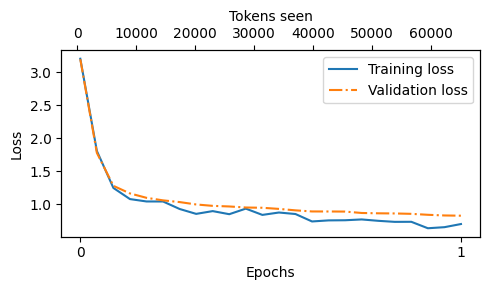

In [70]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [74]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is fast.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> A type of cloud is typically associated with thunderstorms.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prejudice' is Robert Frost.

In [75]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [16:58<00:00,  9.26s/it]


In [76]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is very fast.'}


In [77]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-small124M-sft.pth


In [80]:
import requests
import json

def query_model(
    prompt,
    system_prompt=None,  # New: Allow for a system prompt
    model="llama3",
    url="http://localhost:11434/api/chat",
    seed=123,            # Make seed a parameter
    temperature=0,       # Make temperature a parameter
    num_ctx=8192         # Increase default context window
):
    """
    A robust function to query the Ollama API for model evaluation.

    Args:
        prompt (str): The user's input prompt.
        system_prompt (str, optional): Instructions for the model's system role.
        model (str): The name of the Ollama model to use.
        url (str): The Ollama API endpoint.
        seed (int): Seed for deterministic output.
        temperature (float): Temperature setting (0 for deterministic).
        num_ctx (int): Context window size.

    Returns:
        str: The full model response.

    Raises:
        Exception: If the API request fails or returns an error.
    """
    # Build the messages list
    messages = []
    if system_prompt:
        messages.append({"role": "system", "content": system_prompt})
    messages.append({"role": "user", "content": prompt})

    # Create the data payload
    data = {
        "model": model,
        "messages": messages,
        "stream": True,  # Keep streaming for efficiency
        "options": {
            "seed": seed,
            "temperature": temperature,
            "num_ctx": num_ctx
        }
    }

    try:
        # Use a session for connection pooling and better performance
        with requests.Session() as session:
            response = session.post(url, json=data, stream=True, timeout=60)
            response.raise_for_status()  # Raises an HTTPError for bad status codes (4xx, 5xx)

            full_response = ""
            # Iterate over streaming lines
            for line in response.iter_lines(decode_unicode=True):
                if line:
                    try:
                        # Ollama's streaming response is a series of JSON objects
                        json_chunk = json.loads(line)
                        # Check for a final "done" message or an error
                        if json_chunk.get("done", False):
                            break
                        if "error" in json_chunk:
                            raise Exception(f"Ollama API Error: {json_chunk['error']}")
                        # Append the content from this chunk
                        content = json_chunk.get("message", {}).get("content", "")
                        full_response += content
                    except json.JSONDecodeError as e:
                        # Log the error and the problematic line, but try to continue
                        print(f"Failed to decode JSON line: {line}. Error: {e}")
                        continue

            return full_response

    except requests.exceptions.RequestException as e:
        # Handle connection errors, timeouts, etc.
        raise Exception(f"Request to Ollama API failed: {e}") from e

# Example usage for evaluation:
system_instruction = """
You are an accuracy evaluator. You will be given a question and an assistant's answer.
Your task is to evaluate the answer based on its factual correctness.
Output ONLY a single integer between 1 and 5, where:
1 = Completely Incorrect
2 = Mostly Incorrect
3-4 = Partially Correct with some errors
5 = Completely Correct
Do not output any other text or explanation.
"""

question = "What is the capital of France?"
assistant_answer = "The capital of France is Paris."

eval_prompt = f"QUESTION: {question}\nANSWER: {assistant_answer}"

try:
    # This is the call you would run for each item in your evaluation dataset
    score = query_model(
        prompt=eval_prompt,
        system_prompt=system_instruction,
        model="llama3.2:1b", # Use a smaller model for evaluation in Colab
        seed=456, # You can change the seed for different evaluation runs
        temperature=0
    )
    print(f"Model output: '{score}'")
    # You would then parse the string '5' into an integer and log it
    # final_score = int(score.strip())

except Exception as e:
    print(f"Evaluation failed: {e}")

Evaluation failed: Request to Ollama API failed: HTTPConnectionPool(host='localhost', port=11434): Max retries exceeded with url: /api/chat (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7a60c43e3020>: Failed to establish a new connection: [Errno 111] Connection refused'))


In [83]:

!pip install -q transformers accelerate sentencepiece huggingface-hub


from huggingface_hub import login
login(token="HF token")  # <-- Replace with your HF token


from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_name = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"
)

# Step 4: Create a pipeline
text_generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer
)

# Step 5: Prompt the model
prompt = "I have tomatoes, basil, and cheese at home. What can I cook for dinner?"
sequences = text_generator(prompt, max_new_tokens=150, temperature=0.7)

# Step 6: Print results
for seq in sequences:
    print(seq["generated_text"])


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
403 Client Error. (Request ID: Root=1-68b1a19d-42b352de290f9af817b6bec0;10d606ca-2639-4140-b169-4eea5ad3f3fa)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted and you are not in the authorized list. Visit https://huggingface.co/meta-llama/Llama-2-7b-chat-hf to ask for access.

In [84]:
# Reload the model with the fine-tuned weights
model = GPTModel(BASE_CONFIG)
model.load_state_dict(torch.load("gpt2-small124M-sft.pth"))
model.to(device)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [85]:
# Test with some instructions
test_instructions = [
    {"instruction": "Explain what a black hole is in simple terms.", "input": ""},
    {"instruction": "Write a short poem about nature.", "input": ""},
    {"instruction": "Translate the following sentence to Spanish:", "input": "Hello, how are you?"}
]

for entry in test_instructions:
    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Explain what a black hole is in simple terms.

Model response:
>> A black hole is a region of matter that is formed by a massive explosion of matter. It is a region of matter that is formed by a massive explosion of matter.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Write a short poem about nature.

Model response:
>> The poem is called 'The Nature of Nature'.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Translate the following sentence to Spanish:

### Input:
Hello, how are you?

Model response:
>> I am very happy.
-------------------------------------
